In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms


from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, getTotalLength, mergeSublistsWithSharedItems, initDataset, minimizeProduct
from utils.load import getSamples, getTopofeature, extractWeights
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

In [2]:


trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_normal_save/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))

modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
weight_keys_resnet = ["conv1.weight", "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer1.2.conv1.weight", "layer1.2.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight",
 "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer3.2.conv1.weight", "layer3.2.conv2.weight"]

if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 64
    weight_keys = weight_keys_resnet
else:
    assert 0==1


Files already downloaded and verified
rounds [32, 34, 36, 22, 24, 26, 28, 30] 8
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640


In [11]:
now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S")

corr_set = []
normal_nums = int(client_max)
attack_nums = int(client_max/5)
total_nums = normal_nums+attack_nums

for idround, round_number in enumerate(round_set):
    # if idround >= 1:
    #     break
    r_modelpth_set = modelpth_dict[f'{r}_normal'][0:normal_nums] + modelpth_dict[f'{r}_attack'][0:attack_nums]
    r_corr = np.zeros((total_nums, total_nums, 1))

    topofeaturelist = []
    gradientlist = []
    model, Dataloader, dataset = initDataset(modelname)
    for idx, modelp1 in enumerate(r_modelpth_set):
            gradientlist.append(getGradients(modelpth=modelp1, model=model, dataloader=Dataloader))
            # topofeaturelist.append(getTopofeature(modelpth=modelp1, model=model, dataloader=Dataloader, dataset=dataset))
            topofeaturelist.append([])

    vectors = zip(gradientlist, topofeaturelist)
    # for items in vectors:
    #     print(items)
    
    for id1, v1 in enumerate(copy.deepcopy(vectors)):
        if id1 >= total_nums:
            break
        local_grad_1 = [v1[0][key] for key in weight_keys]
        for id2, v2 in enumerate(copy.deepcopy(vectors)):
            if id2 >= total_nums:
                break
            if id2 <= id1:
                continue

            local_grad_2 = [v2[0][key] for key in weight_keys]
            corrlist = []

            # # print(gradients1)
            # acts1 = v1[0]["layer3.0.conv1.weight"]
            # acts2 = v2[0]["layer3.0.conv1.weight"]
            
            # acts1 = acts1.cpu().reshape((weightsize,-1))
            # acts2 = acts2.cpu().reshape((weightsize,-1))
            # # fv1 = v1[1].reshape((5,-1))
            # # fv2 = v2[1].reshape((5,-1))
            # # print(acts1-acts2)
            # # print(fv1)
            # l = linear_CKA(acts1.T, acts2.T)
            # k = kernel_CKA(acts1.T, acts2.T)
            # # lfv = linear_CKA(fv1, fv2)
            # # kfv = linear_CKA(fv1, fv2)
            # corrlist.append((l+k)/4)
            for layer_id, _ in enumerate(local_grad_1):
                nd_vector = np.prod(local_grad_1[layer_id].cpu().shape)

                ly1 = local_grad_1[layer_id].cpu().reshape(minimizeProduct(nd_vector)[0])
                ly2 = local_grad_2[layer_id].cpu().reshape(minimizeProduct(nd_vector)[0])

                l = linear_CKA(ly1.T, ly2.T)
                k = kernel_CKA(ly1.T, ly2.T)

                corrlist.append((l+k)/2)

            r_corr[id1][id2] = np.mean(np.array(corrlist))
    
    corr_set.append([round_number, r_corr])

print(len(corr_set))
print(corr_set[0][1].shape)
    

Files already downloaded and verified
Files already downloaded and verified


Traceback (most recent call last):


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
8
(36, 36, 1)


In [12]:
np.savetxt(f"./data/corrset_temp_{formatted_date_time}.txt",np.array([row[1] for row in corr_set]).reshape(len(corr_set), -1))
print(formatted_date_time)

2023-12-24 23:35:53


# PCODE

In [13]:
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps

32 (36, 36)


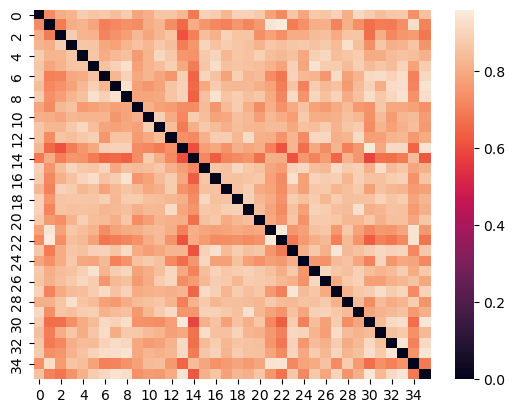

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


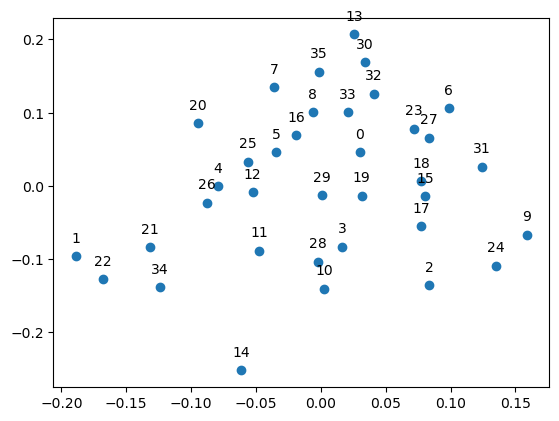

d 0 0 0.0 inf []
d 0 1 0.0 0.12252431362680427 [[10, 14]]
d 0 2 0.0 0.12076513418672319 [[9, 18]]
d 0 3 0.0 0.11920618656174775 [[28, 34]]
d 0 4 0.0 0.11491692037361434 [[4, 20]]
d 0 5 0.0 0.11305858994259643 [[10, 11]]
d 0 6 0.0 0.11285521880971172 [[17, 19]]
d 0 7 0.0 0.10663966527711577 [[2, 17]]
d 0 8 0.0 0.09875939942416945 [[3, 15]]
d 0 9 0.0 0.09143948301282823 [[15, 24]]
d 0 10 0.0 0.09135254212152832 [[4, 26]]
d 0 11 0.0 0.09105919461717082 [[25, 26]]
d 0 12 0.0 0.08917620410106186 [[15, 18]]
d 0 13 0.0 0.0890505902584916 [[4, 11]]
d 0 14 0.0 0.08904049140769199 [[12, 25]]
d 0 15 0.0 0.08692012313232778 [[0, 29]]
d 0 16 0.0 0.08375607841797583 [[12, 29]]
d 0 17 0.0 0.07564525203635519 [[6, 33]]
d 0 18 0.0 0.07500843014282699 [[15, 31]]
d 0 19 0.0 0.07415333721796868 [[27, 31]]
d 0 20 0.0 0.06881614173838513 [[5, 8]]
d 0 21 0.0 0.06878081910507727 [[16, 23]]
d 0 22 0.0 0.06874295130263297 [[3, 28]]
d 0 23 0.0 0.06868331296106411 [[19, 29]]
d 0 24 0.0 0.06487885460160836 [[7, 8]

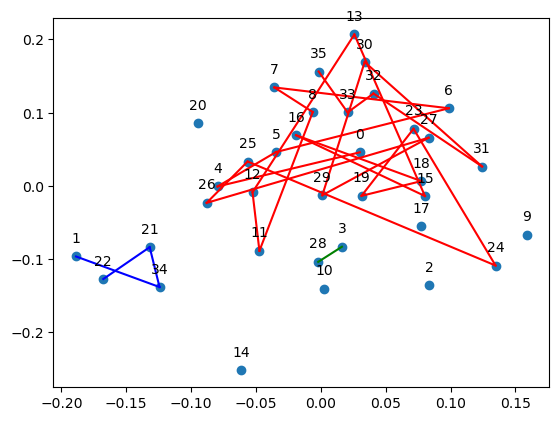

persistence =0.10663966527711577, finding: [3, 15]
 [[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[3, 28], [0, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.556349186104045 15.556349186104045
pbow:
[array([ 0.,  9., 11.,  5.]), array([1., 0., 0., 2.])]
[[ 0.         14.56021978]
 [14.56021978  0.        ]]
score x0.5: [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


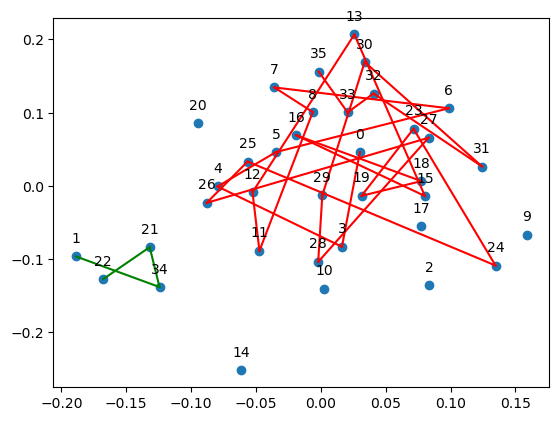

persistence =0.11285521880971172, finding: [2, 17]
 [[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[]
[]
pbow:
[array([0., 1.]), array([16.,  9.]), array([3., 0.])]
[[ 0.         17.88854382  3.16227766]
 [17.88854382  0.         15.8113883 ]
 [ 3.16227766 15.8113883   0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


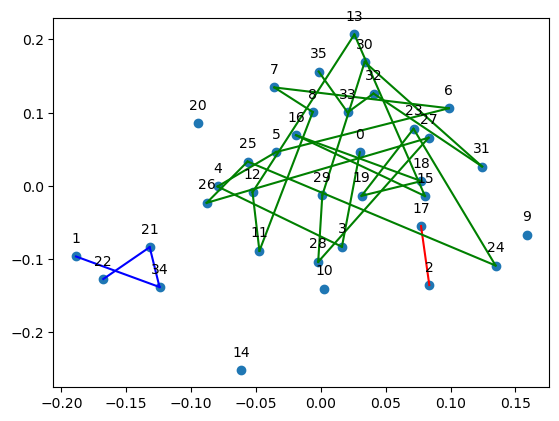

persistence =0.11305858994259643, finding: [17, 19]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [2, 17]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.88854381999832 17.88854381999832
pbow:
[array([ 5.,  8., 11.,  3.]), array([3., 0., 0., 0.])]
[[ 0.         14.07124728]
 [14.07124728  0.        ]]
score x0.5333333333333333: [0.17857142857142858] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


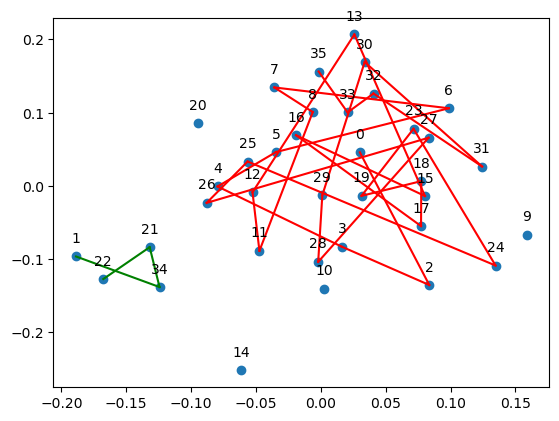

persistence =0.11491692037361434, finding: [10, 11]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[10]]
[[0, 0]]
pbow:
[array([ 9., 11.,  3.,  5.]), array([0., 0., 0., 3.])]
[[ 0.        14.6628783]
 [14.6628783  0.       ]]
score x0.55: [0.1724137931034483] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


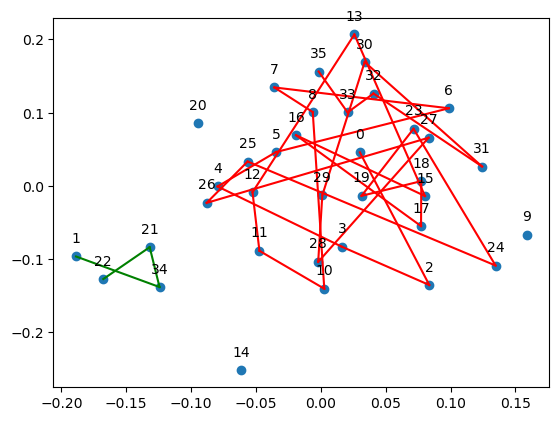

persistence =0.11920618656174775, finding: [4, 20]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[20]]
[[0, 0]]
pbow:
[array([ 5.,  9.,  4., 11.]), array([3., 0., 0., 0.])]
[[ 0.         14.89966443]
 [14.89966443  0.        ]]
score x0.5666666666666667: [0.16666666666666666] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


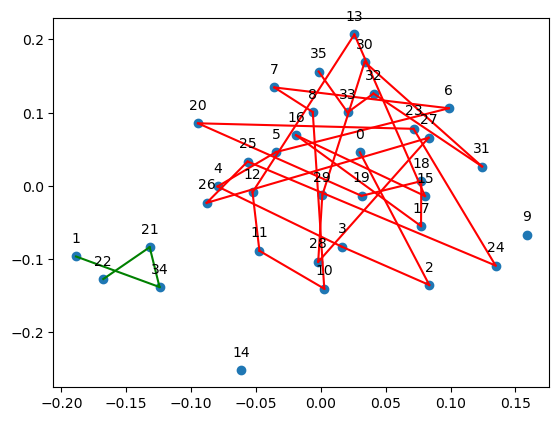

persistence =0.12076513418672319, finding: [28, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[1, 21, 22, 34], [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.89966442575134 14.89966442575134
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.12252431362680427, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[9]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



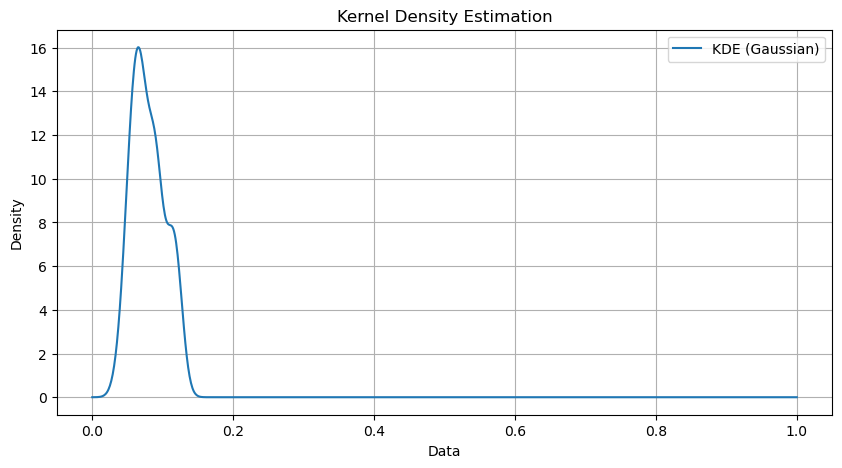

34 (36, 36)


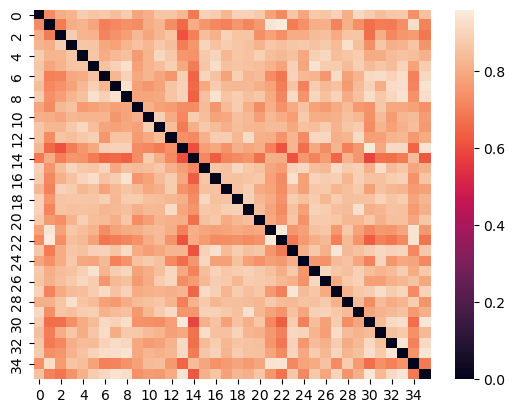

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


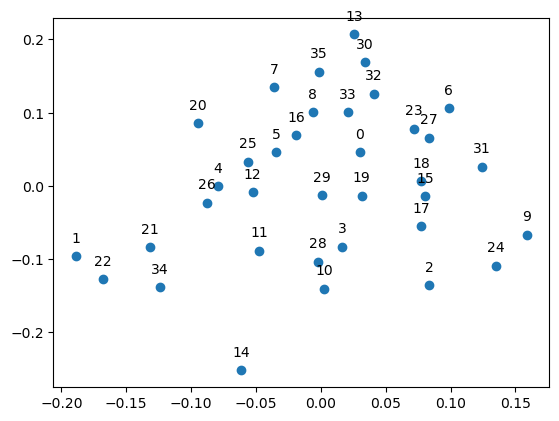

d 0 0 0.0 inf []
d 0 1 0.0 0.1225243188410331 [[10, 14]]
d 0 2 0.0 0.12076510482111757 [[9, 18]]
d 0 3 0.0 0.11920610510867058 [[28, 34]]
d 0 4 0.0 0.1149169199058735 [[4, 20]]
d 0 5 0.0 0.11305858676774172 [[10, 11]]
d 0 6 0.0 0.11285521962700873 [[17, 19]]
d 0 7 0.0 0.10663972990997816 [[2, 17]]
d 0 8 0.0 0.09875939774427422 [[3, 15]]
d 0 9 0.0 0.09143948263033286 [[15, 24]]
d 0 10 0.0 0.09135254312454766 [[4, 26]]
d 0 11 0.0 0.0910592962246598 [[25, 26]]
d 0 12 0.0 0.08917620286600514 [[15, 18]]
d 0 13 0.0 0.08905059257484671 [[4, 11]]
d 0 14 0.0 0.0890406207373341 [[12, 25]]
d 0 15 0.0 0.0869201287948822 [[0, 29]]
d 0 16 0.0 0.08375607761706838 [[12, 29]]
d 0 17 0.0 0.07564524720246124 [[6, 33]]
d 0 18 0.0 0.07500843195571938 [[15, 31]]
d 0 19 0.0 0.07415326521905974 [[27, 31]]
d 0 20 0.0 0.0688161422370307 [[5, 8]]
d 0 21 0.0 0.0687808165475361 [[16, 23]]
d 0 22 0.0 0.06874295061588687 [[3, 28]]
d 0 23 0.0 0.0686833127364791 [[19, 29]]
d 0 24 0.0 0.06487887866979769 [[7, 8]]
d 0 2

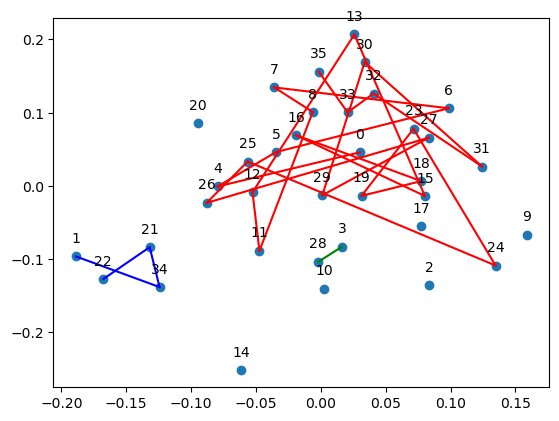

persistence =0.10663972990997816, finding: [3, 15]
 [[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[3, 28], [0, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.556349186104045 15.556349186104045
pbow:
[array([ 5.,  9., 11.,  0.]), array([2., 0., 0., 1.])]
[[ 0.         14.56021978]
 [14.56021978  0.        ]]
score x0.5: [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


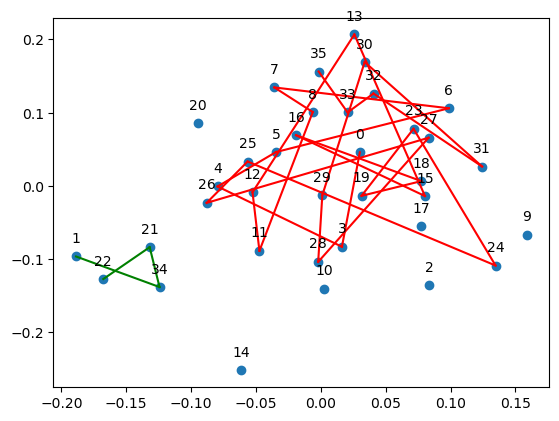

persistence =0.11285521962700873, finding: [2, 17]
 [[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[]
[]
pbow:
[array([0., 1.]), array([16.,  9.]), array([3., 0.])]
[[ 0.         17.88854382  3.16227766]
 [17.88854382  0.         15.8113883 ]
 [ 3.16227766 15.8113883   0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


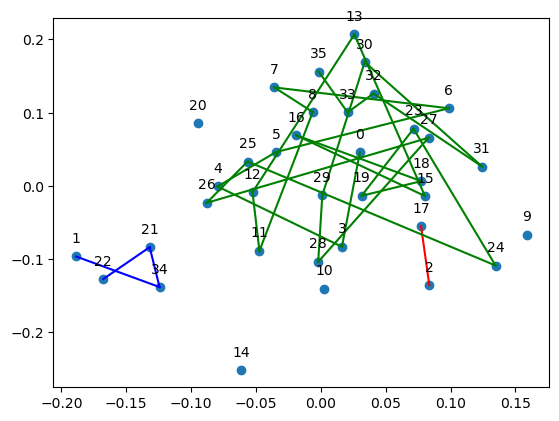

persistence =0.11305858676774172, finding: [17, 19]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [2, 17]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.88854381999832 17.88854381999832
pbow:
[array([ 5.,  8., 11.,  3.]), array([3., 0., 0., 0.])]
[[ 0.         14.07124728]
 [14.07124728  0.        ]]
score x0.5333333333333333: [0.17857142857142858] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


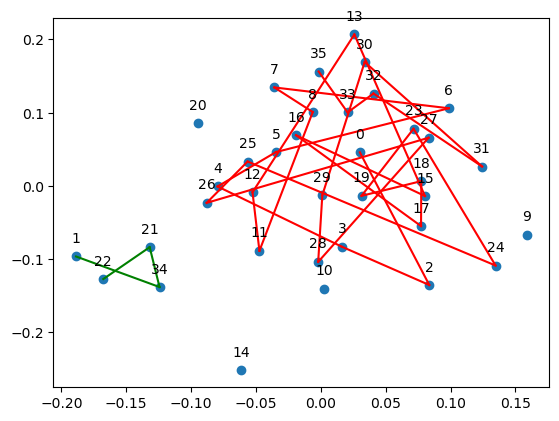

persistence =0.1149169199058735, finding: [10, 11]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[10]]
[[0, 0]]
pbow:
[array([ 9.,  5., 11.,  3.]), array([0., 3., 0., 0.])]
[[ 0.        14.6628783]
 [14.6628783  0.       ]]
score x0.55: [0.1724137931034483] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


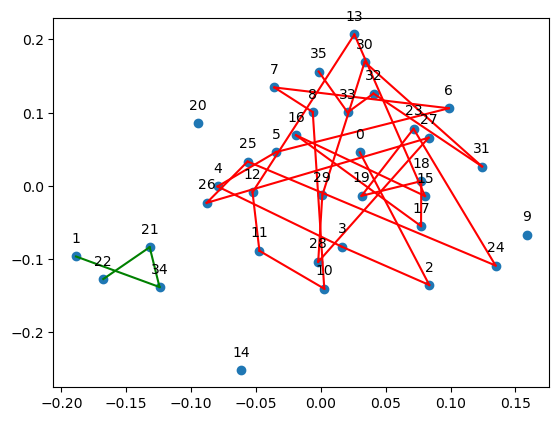

persistence =0.11920610510867058, finding: [4, 20]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[20]]
[[0, 0]]
pbow:
[array([ 9.,  5.,  4., 11.]), array([0., 3., 0., 0.])]
[[ 0.         14.89966443]
 [14.89966443  0.        ]]
score x0.5666666666666667: [0.16666666666666666] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


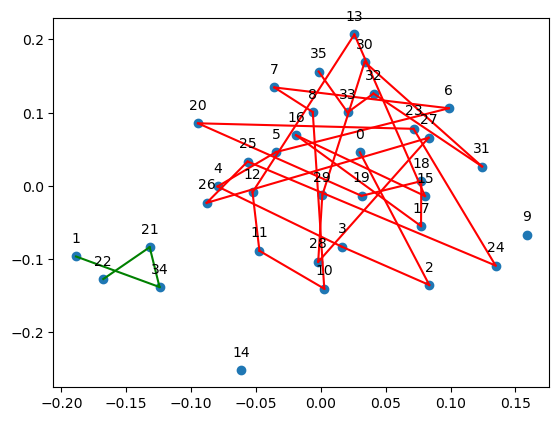

persistence =0.12076510482111757, finding: [28, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[1, 21, 22, 34], [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.89966442575134 14.89966442575134
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.1225243188410331, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[9]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



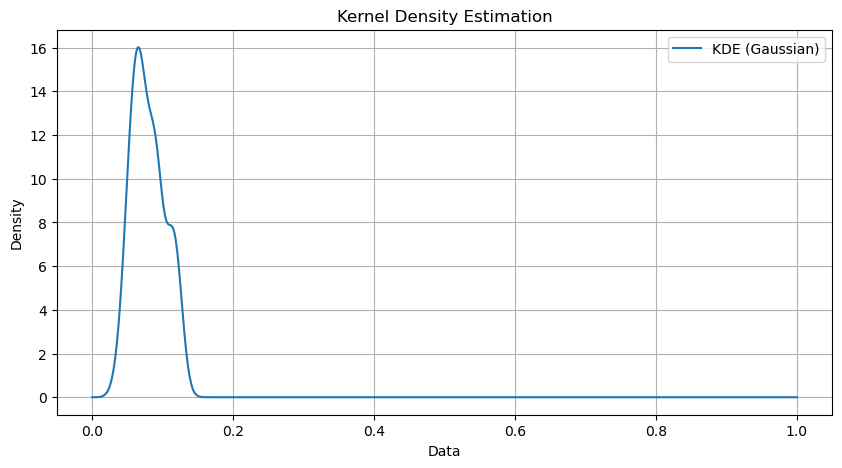

36 (36, 36)


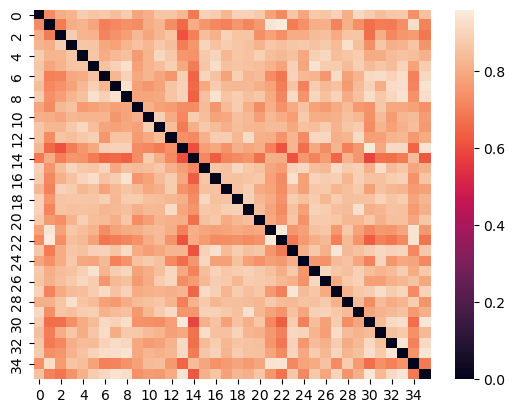

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


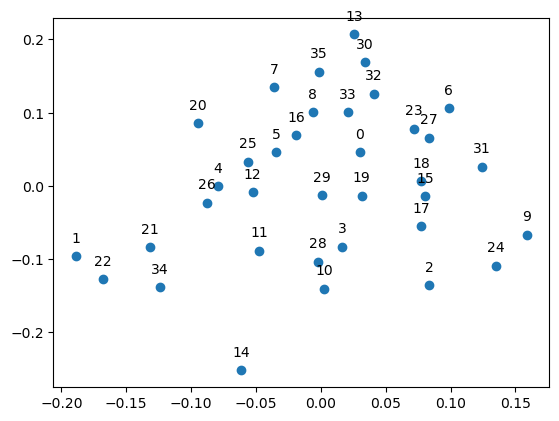

d 0 0 0.0 inf []
d 0 1 0.0 0.12252431609835912 [[10, 14]]
d 0 2 0.0 0.12076519698032617 [[9, 18]]
d 0 3 0.0 0.11920610442420476 [[28, 34]]
d 0 4 0.0 0.1149170073965643 [[4, 20]]
d 0 5 0.0 0.11305858567785254 [[10, 11]]
d 0 6 0.0 0.11285523048687585 [[17, 19]]
d 0 7 0.0 0.10663968103852783 [[2, 17]]
d 0 8 0.0 0.09875939932452893 [[3, 15]]
d 0 9 0.0 0.09143950603744211 [[15, 24]]
d 0 10 0.0 0.09135260736901818 [[4, 26]]
d 0 11 0.0 0.0910592601475455 [[25, 26]]
d 0 12 0.0 0.08917620322702946 [[15, 18]]
d 0 13 0.0 0.08905060135813048 [[4, 11]]
d 0 14 0.0 0.08904052878726676 [[12, 25]]
d 0 15 0.0 0.08692012340431088 [[0, 29]]
d 0 16 0.0 0.0837560782050879 [[12, 29]]
d 0 17 0.0 0.07564537161176332 [[6, 33]]
d 0 18 0.0 0.07500844772277027 [[15, 31]]
d 0 19 0.0 0.07415334831944376 [[27, 31]]
d 0 20 0.0 0.06881615103628502 [[5, 8]]
d 0 21 0.0 0.0687808171154709 [[16, 23]]
d 0 22 0.0 0.06874295028923316 [[3, 28]]
d 0 23 0.0 0.06868337572412497 [[19, 29]]
d 0 24 0.0 0.06487868169415878 [[7, 8]]
d

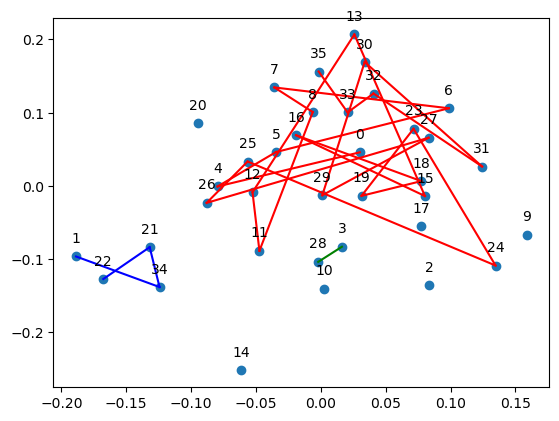

persistence =0.10663968103852783, finding: [3, 15]
 [[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[3, 28], [0, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.556349186104045 15.556349186104045
pbow:
[array([ 5.,  9., 11.,  0.]), array([2., 0., 0., 1.])]
[[ 0.         14.56021978]
 [14.56021978  0.        ]]
score x0.5: [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


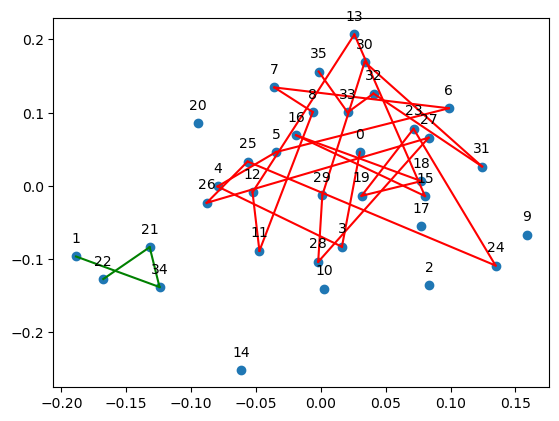

persistence =0.11285523048687585, finding: [2, 17]
 [[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[]
[]
pbow:
[array([1., 0.]), array([ 9., 16.]), array([0., 3.])]
[[ 0.         17.88854382  3.16227766]
 [17.88854382  0.         15.8113883 ]
 [ 3.16227766 15.8113883   0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


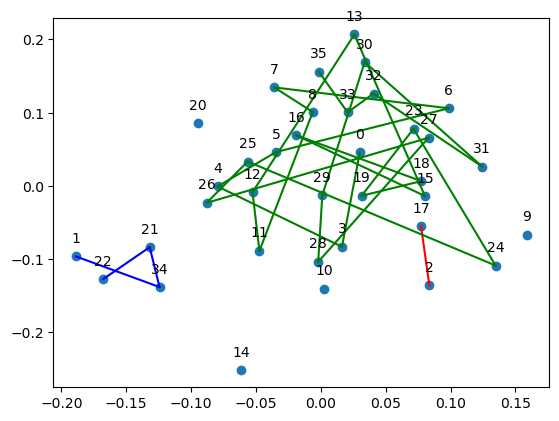

persistence =0.11305858567785254, finding: [17, 19]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [2, 17]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.88854381999832 17.88854381999832
pbow:
[array([ 8., 11.,  5.,  3.]), array([0., 0., 3., 0.])]
[[ 0.         14.07124728]
 [14.07124728  0.        ]]
score x0.5333333333333333: [0.17857142857142858] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


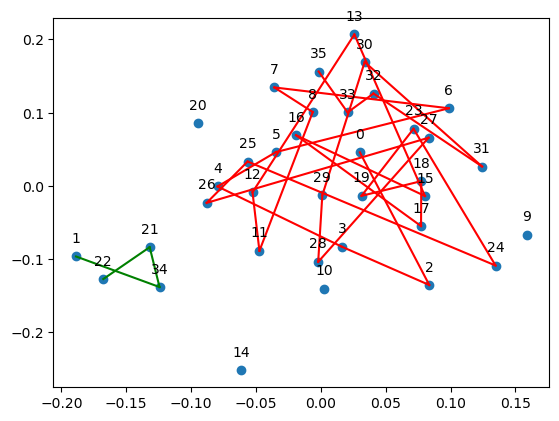

persistence =0.1149170073965643, finding: [10, 11]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[10]]
[[0, 0]]
pbow:
[array([ 5., 11.,  9.,  3.]), array([3., 0., 0., 0.])]
[[ 0.        14.6628783]
 [14.6628783  0.       ]]
score x0.55: [0.1724137931034483] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


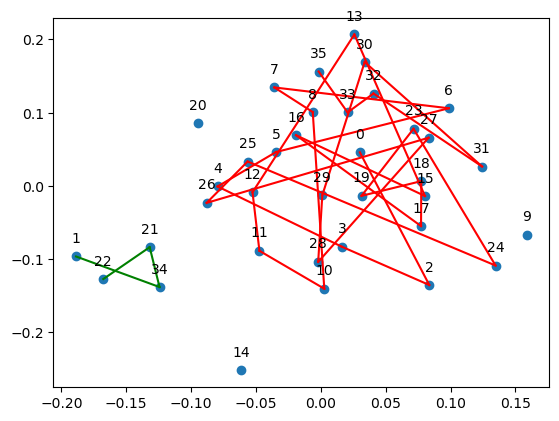

persistence =0.11920610442420476, finding: [4, 20]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[20]]
[[0, 0]]
pbow:
[array([ 9., 11.,  4.,  5.]), array([0., 0., 0., 3.])]
[[ 0.         14.89966443]
 [14.89966443  0.        ]]
score x0.5666666666666667: [0.16666666666666666] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


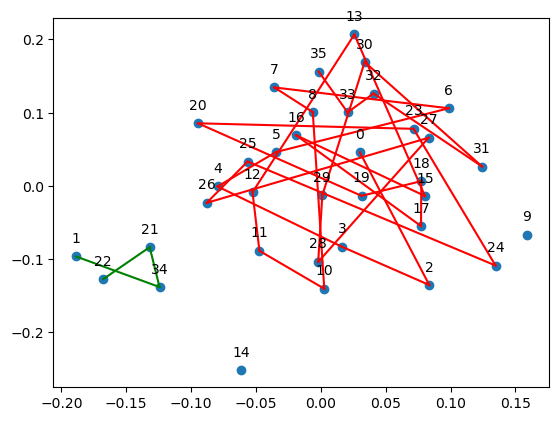

persistence =0.12076519698032617, finding: [28, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[1, 21, 22, 34], [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.89966442575134 14.89966442575134
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.12252431609835912, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[9]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



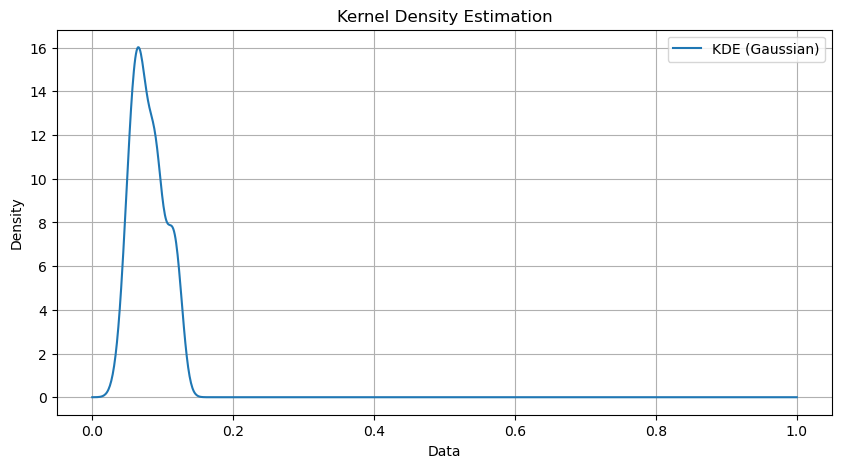

22 (36, 36)


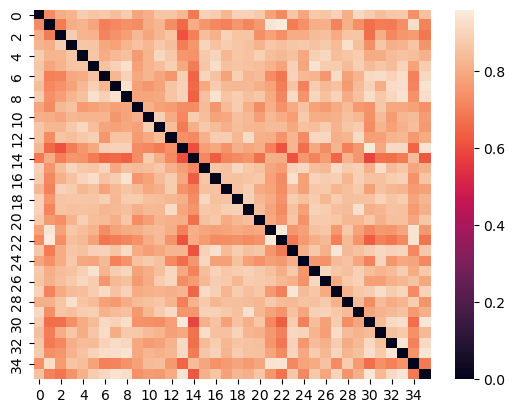

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


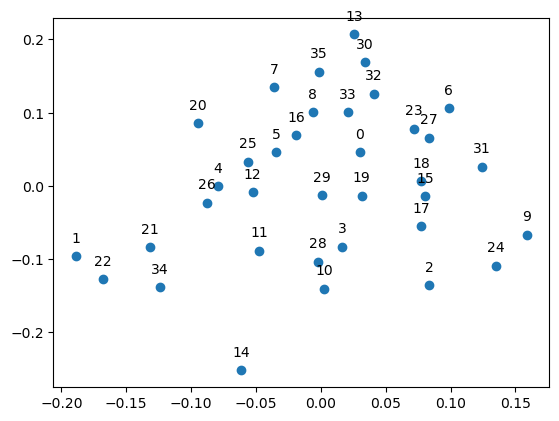

d 0 0 0.0 inf []
d 0 1 0.0 0.12252417813388361 [[10, 14]]
d 0 2 0.0 0.12076510320101264 [[9, 18]]
d 0 3 0.0 0.11920609523957548 [[28, 34]]
d 0 4 0.0 0.11491693801480785 [[4, 20]]
d 0 5 0.0 0.11305858824288006 [[10, 11]]
d 0 6 0.0 0.11285523017626453 [[17, 19]]
d 0 7 0.0 0.10663974676788479 [[2, 17]]
d 0 8 0.0 0.09875948029046999 [[3, 15]]
d 0 9 0.0 0.09143949610216406 [[15, 24]]
d 0 10 0.0 0.09135254184174846 [[4, 26]]
d 0 11 0.0 0.09105919469173507 [[25, 26]]
d 0 12 0.0 0.0891761725621858 [[15, 18]]
d 0 13 0.0 0.08905059064163157 [[4, 11]]
d 0 14 0.0 0.08904049125455338 [[12, 25]]
d 0 15 0.0 0.0869202573875858 [[0, 29]]
d 0 16 0.0 0.08375604861320884 [[12, 29]]
d 0 17 0.0 0.07564525462368199 [[6, 33]]
d 0 18 0.0 0.07500820467913127 [[15, 31]]
d 0 19 0.0 0.07415334471552215 [[27, 31]]
d 0 20 0.0 0.06881614331473596 [[5, 8]]
d 0 21 0.0 0.06878081875918285 [[16, 23]]
d 0 22 0.0 0.06874294973200556 [[3, 28]]
d 0 23 0.0 0.068683346214646 [[19, 29]]
d 0 24 0.0 0.0648786734081056 [[7, 8]]
d 

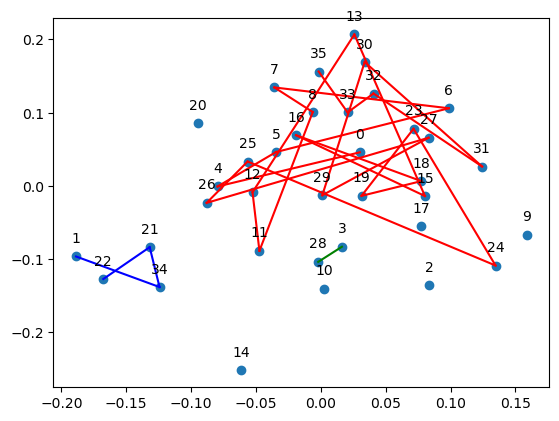

persistence =0.10663974676788479, finding: [3, 15]
 [[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[3, 28], [0, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.556349186104045 15.556349186104045
pbow:
[array([11.,  9.,  0.,  5.]), array([0., 0., 1., 2.])]
[[ 0.         14.56021978]
 [14.56021978  0.        ]]
score x0.5: [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


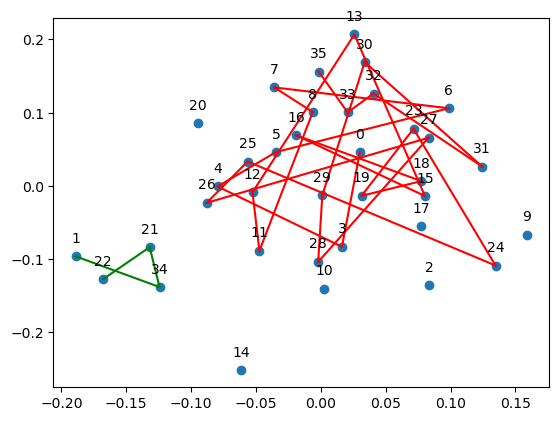

persistence =0.11285523017626453, finding: [2, 17]
 [[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[]
[]
pbow:
[array([1., 0.]), array([ 9., 16.]), array([0., 3.])]
[[ 0.         17.88854382  3.16227766]
 [17.88854382  0.         15.8113883 ]
 [ 3.16227766 15.8113883   0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


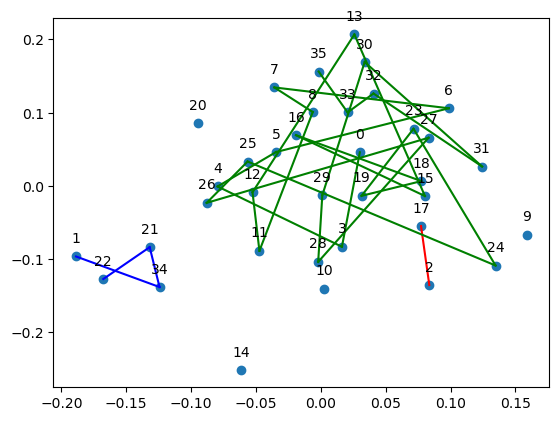

persistence =0.11305858824288006, finding: [17, 19]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [2, 17]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.88854381999832 17.88854381999832
pbow:
[array([11.,  8.,  3.,  5.]), array([0., 0., 0., 3.])]
[[ 0.         14.07124728]
 [14.07124728  0.        ]]
score x0.5333333333333333: [0.17857142857142858] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


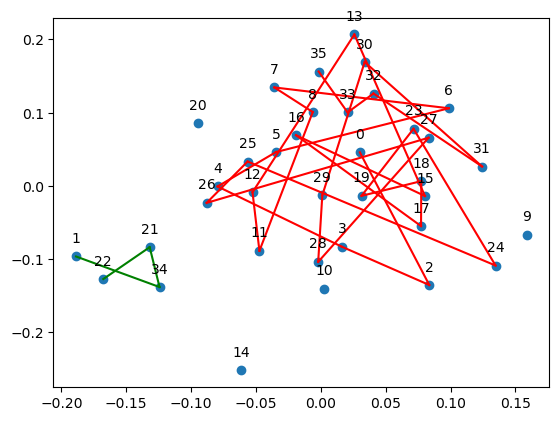

persistence =0.11491693801480785, finding: [10, 11]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[10]]
[[0, 0]]
pbow:
[array([ 5.,  9., 11.,  3.]), array([3., 0., 0., 0.])]
[[ 0.        14.6628783]
 [14.6628783  0.       ]]
score x0.55: [0.1724137931034483] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


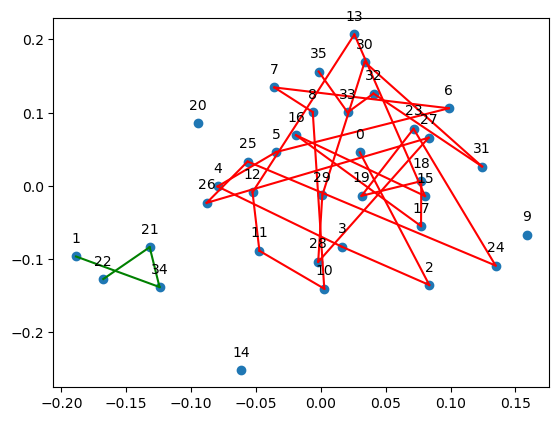

persistence =0.11920609523957548, finding: [4, 20]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[20]]
[[0, 0]]
pbow:
[array([ 9.,  5.,  4., 11.]), array([0., 3., 0., 0.])]
[[ 0.         14.89966443]
 [14.89966443  0.        ]]
score x0.5666666666666667: [0.16666666666666666] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


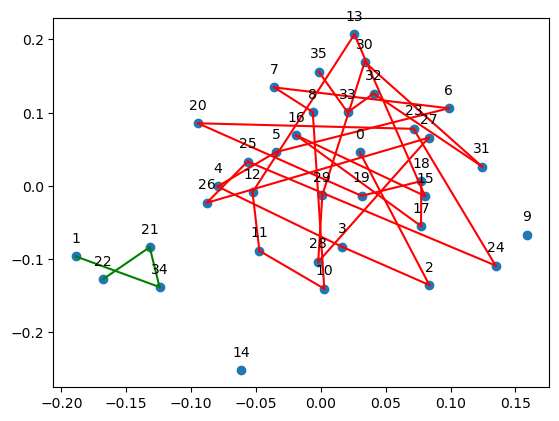

persistence =0.12076510320101264, finding: [28, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[1, 21, 22, 34], [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.89966442575134 14.89966442575134
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.12252417813388361, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[9]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



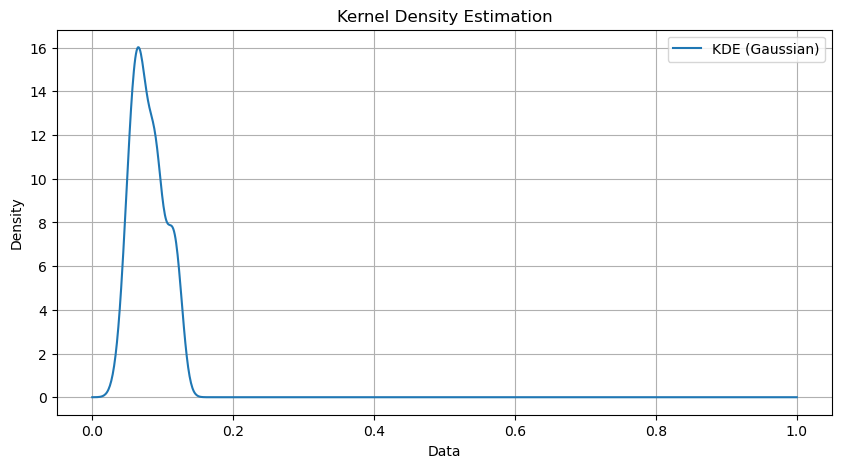

24 (36, 36)


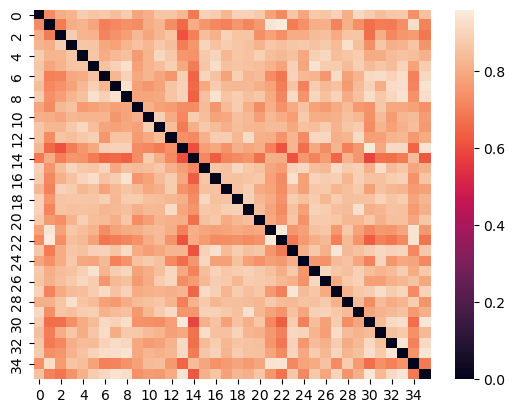

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


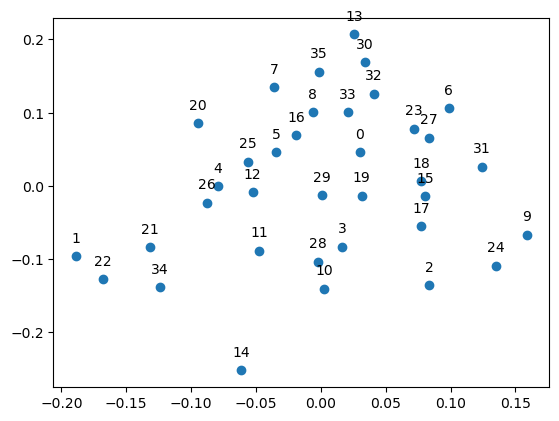

d 0 0 0.0 inf []
d 0 1 0.0 0.12252427231367291 [[10, 14]]
d 0 2 0.0 0.12076513555937773 [[9, 18]]
d 0 3 0.0 0.11920618758667234 [[28, 34]]
d 0 4 0.0 0.11491693695446437 [[4, 20]]
d 0 5 0.0 0.11305858396880286 [[10, 11]]
d 0 6 0.0 0.11285522947386517 [[17, 19]]
d 0 7 0.0 0.10663974428094447 [[2, 17]]
d 0 8 0.0 0.09875939865483552 [[3, 15]]
d 0 9 0.0 0.091439483016579 [[15, 24]]
d 0 10 0.0 0.09135254195432496 [[4, 26]]
d 0 11 0.0 0.09105922934216981 [[25, 26]]
d 0 12 0.0 0.08917620218239963 [[15, 18]]
d 0 13 0.0 0.08905055016437868 [[4, 11]]
d 0 14 0.0 0.08904058299526152 [[12, 25]]
d 0 15 0.0 0.08692026174575784 [[0, 29]]
d 0 16 0.0 0.08375604815734261 [[12, 29]]
d 0 17 0.0 0.07564525305687686 [[6, 33]]
d 0 18 0.0 0.07500843216425235 [[15, 31]]
d 0 19 0.0 0.0741533381575048 [[27, 31]]
d 0 20 0.0 0.06881616138105107 [[5, 8]]
d 0 21 0.0 0.06878081701069738 [[16, 23]]
d 0 22 0.0 0.06874295061341551 [[3, 28]]
d 0 23 0.0 0.06868334500839468 [[19, 29]]
d 0 24 0.0 0.06487869575912564 [[7, 8]]


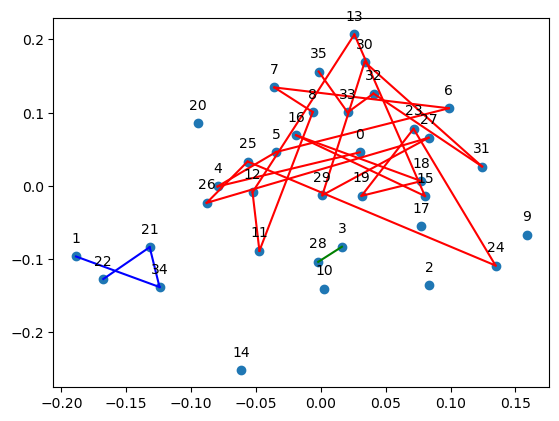

persistence =0.10663974428094447, finding: [3, 15]
 [[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[3, 28], [0, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.556349186104045 15.556349186104045
pbow:
[array([ 9., 11.,  0.,  5.]), array([0., 0., 1., 2.])]
[[ 0.         14.56021978]
 [14.56021978  0.        ]]
score x0.5: [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


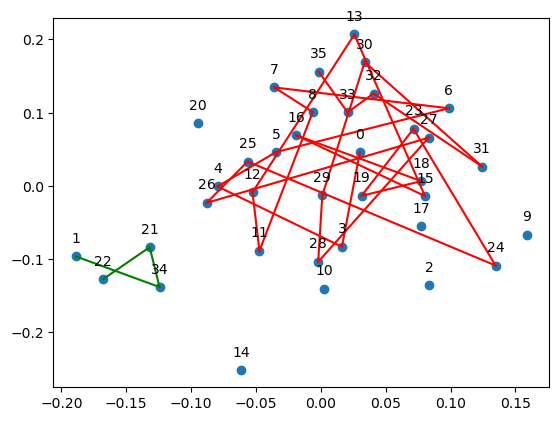

persistence =0.11285522947386517, finding: [2, 17]
 [[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[]
[]
pbow:
[array([0., 1.]), array([16.,  9.]), array([3., 0.])]
[[ 0.         17.88854382  3.16227766]
 [17.88854382  0.         15.8113883 ]
 [ 3.16227766 15.8113883   0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


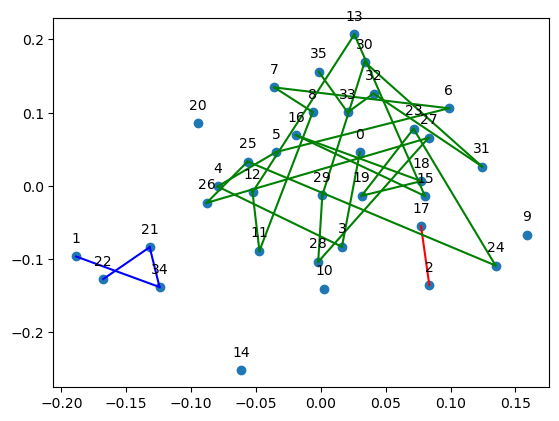

persistence =0.11305858396880286, finding: [17, 19]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [2, 17]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.88854381999832 17.88854381999832
pbow:
[array([ 8., 11.,  3.,  5.]), array([0., 0., 0., 3.])]
[[ 0.         14.07124728]
 [14.07124728  0.        ]]
score x0.5333333333333333: [0.17857142857142858] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


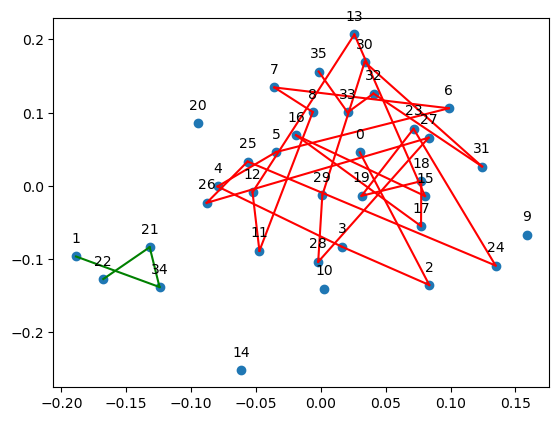

persistence =0.11491693695446437, finding: [10, 11]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[10]]
[[0, 0]]
pbow:
[array([11.,  9.,  5.,  3.]), array([0., 0., 3., 0.])]
[[ 0.        14.6628783]
 [14.6628783  0.       ]]
score x0.55: [0.1724137931034483] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


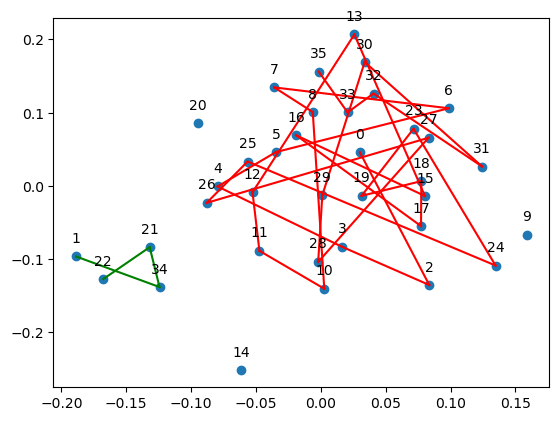

persistence =0.11920618758667234, finding: [4, 20]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[20]]
[[0, 0]]
pbow:
[array([11.,  9.,  4.,  5.]), array([0., 0., 0., 3.])]
[[ 0.         14.89966443]
 [14.89966443  0.        ]]
score x0.5666666666666667: [0.16666666666666666] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


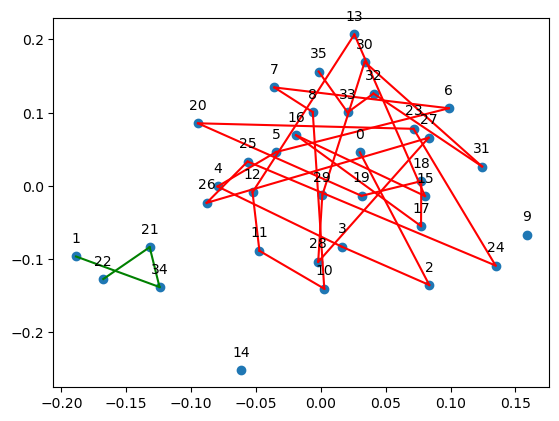

persistence =0.12076513555937773, finding: [28, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[1, 21, 22, 34], [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.89966442575134 14.89966442575134
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.12252427231367291, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[9]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



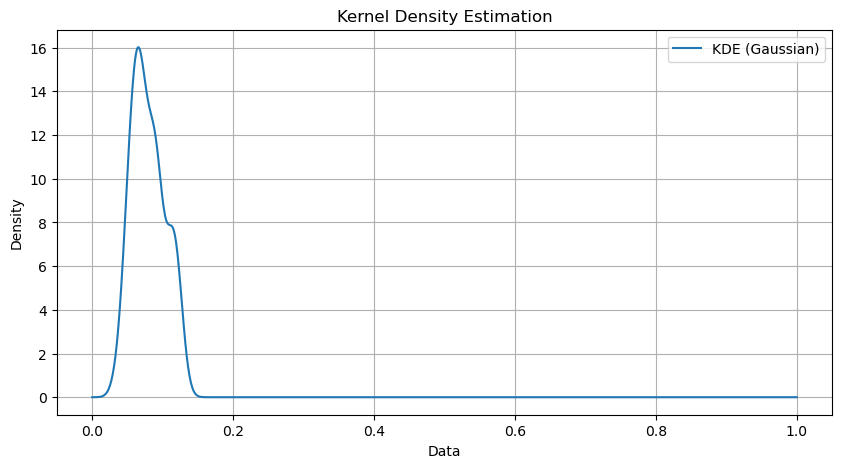

26 (36, 36)


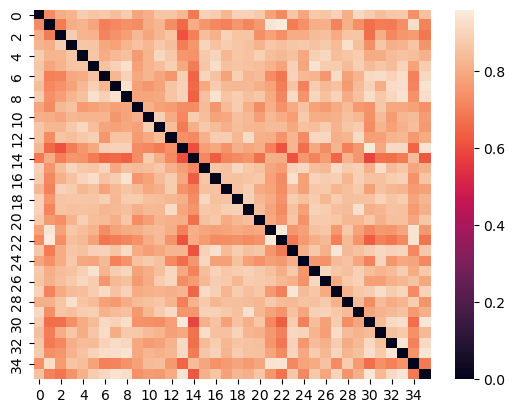

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


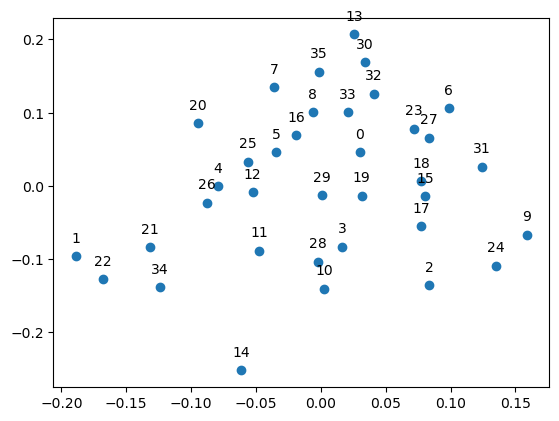

d 0 0 0.0 inf []
d 0 1 0.0 0.12252431161692234 [[10, 14]]
d 0 2 0.0 0.12076513488279139 [[9, 18]]
d 0 3 0.0 0.11920618542061734 [[28, 34]]
d 0 4 0.0 0.11491691868731024 [[4, 20]]
d 0 5 0.0 0.11305858892199161 [[10, 11]]
d 0 6 0.0 0.1128552188272034 [[17, 19]]
d 0 7 0.0 0.10663969748848989 [[2, 17]]
d 0 8 0.0 0.0987593996130618 [[3, 15]]
d 0 9 0.0 0.09143950447855154 [[15, 24]]
d 0 10 0.0 0.0913525423456949 [[4, 26]]
d 0 11 0.0 0.09105910554243202 [[25, 26]]
d 0 12 0.0 0.08917620203949361 [[15, 18]]
d 0 13 0.0 0.08905058836907676 [[4, 11]]
d 0 14 0.0 0.08904050076155479 [[12, 25]]
d 0 15 0.0 0.08692012991529463 [[0, 29]]
d 0 16 0.0 0.08375604015645899 [[12, 29]]
d 0 17 0.0 0.07564540646427831 [[6, 33]]
d 0 18 0.0 0.07500843176510796 [[15, 31]]
d 0 19 0.0 0.07415333997765272 [[27, 31]]
d 0 20 0.0 0.06881614239332601 [[5, 8]]
d 0 21 0.0 0.06878082015633946 [[16, 23]]
d 0 22 0.0 0.06874295144217324 [[3, 28]]
d 0 23 0.0 0.06868331339417655 [[19, 29]]
d 0 24 0.0 0.06487864417127387 [[7, 8]]


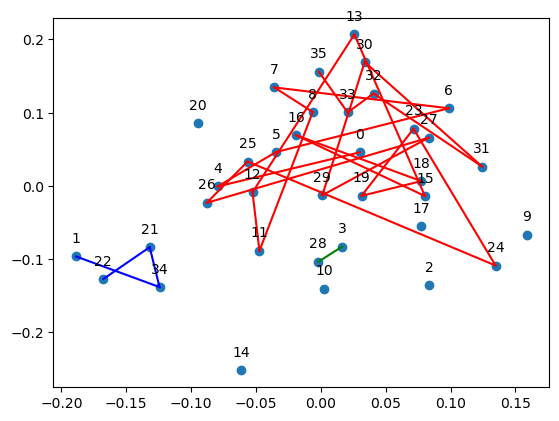

persistence =0.10663969748848989, finding: [3, 15]
 [[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[3, 28], [0, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.556349186104045 15.556349186104045
pbow:
[array([ 5.,  9., 11.,  0.]), array([2., 0., 0., 1.])]
[[ 0.         14.56021978]
 [14.56021978  0.        ]]
score x0.5: [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


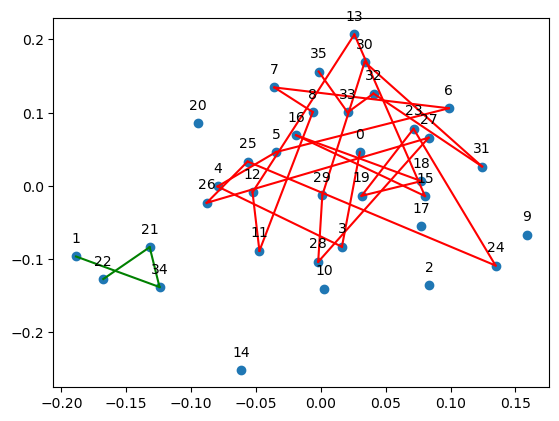

persistence =0.1128552188272034, finding: [2, 17]
 [[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[]
[]
pbow:
[array([0., 1.]), array([16.,  9.]), array([3., 0.])]
[[ 0.         17.88854382  3.16227766]
 [17.88854382  0.         15.8113883 ]
 [ 3.16227766 15.8113883   0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


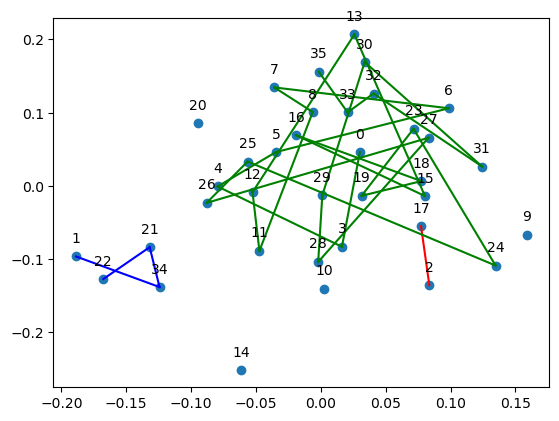

persistence =0.11305858892199161, finding: [17, 19]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [2, 17]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.88854381999832 17.88854381999832
pbow:
[array([ 3., 11.,  8.,  5.]), array([0., 0., 0., 3.])]
[[ 0.         14.07124728]
 [14.07124728  0.        ]]
score x0.5333333333333333: [0.17857142857142858] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


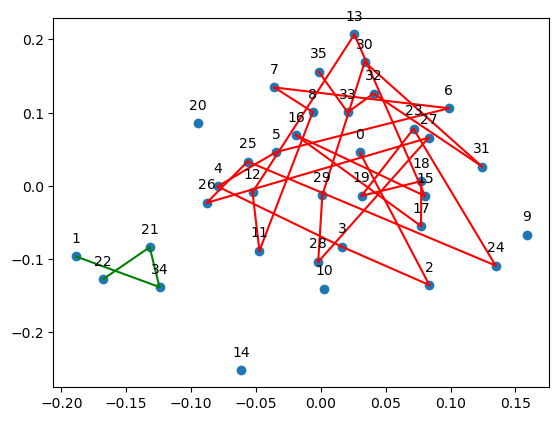

persistence =0.11491691868731024, finding: [10, 11]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[10]]
[[0, 0]]
pbow:
[array([ 9., 11.,  5.,  3.]), array([0., 0., 3., 0.])]
[[ 0.        14.6628783]
 [14.6628783  0.       ]]
score x0.55: [0.1724137931034483] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


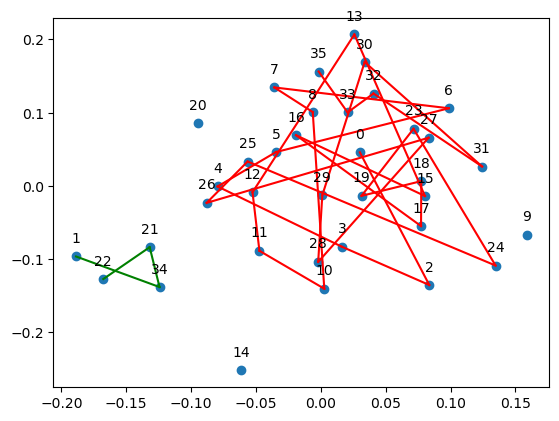

persistence =0.11920618542061734, finding: [4, 20]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[20]]
[[0, 0]]
pbow:
[array([ 4., 11.,  9.,  5.]), array([0., 0., 0., 3.])]
[[ 0.         14.89966443]
 [14.89966443  0.        ]]
score x0.5666666666666667: [0.16666666666666666] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


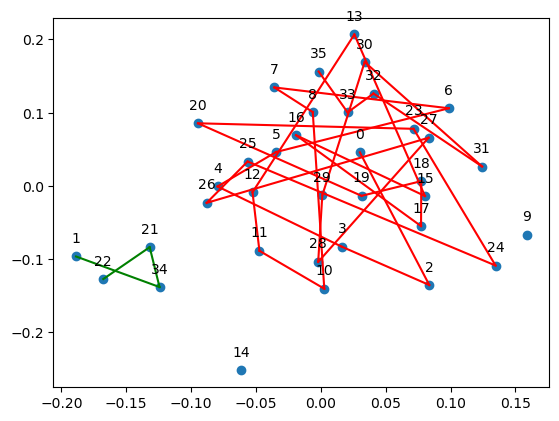

persistence =0.12076513488279139, finding: [28, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[1, 21, 22, 34], [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.89966442575134 14.89966442575134
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.12252431161692234, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[9]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



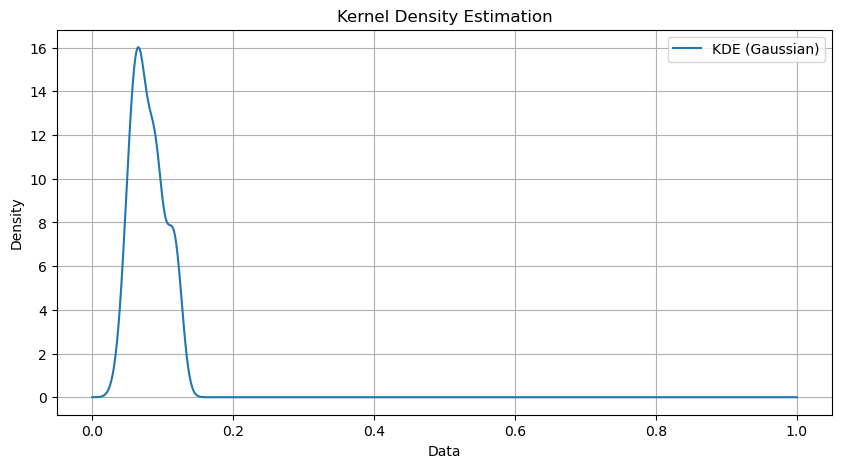

28 (36, 36)


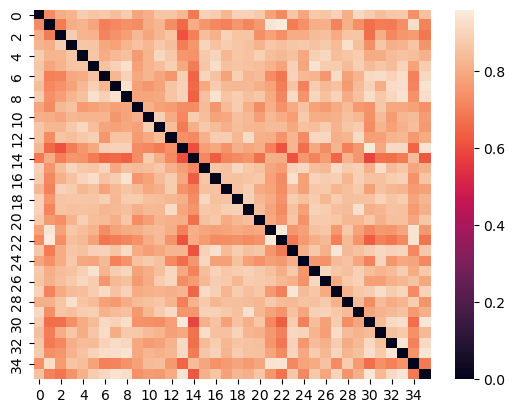

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


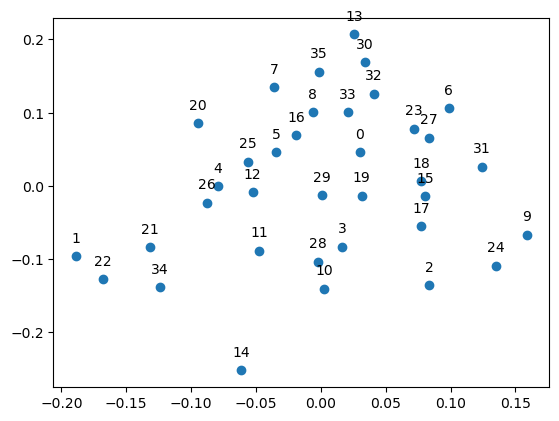

d 0 0 0.0 inf []
d 0 1 0.0 0.12252427278289424 [[10, 14]]
d 0 2 0.0 0.12076519767775173 [[9, 18]]
d 0 3 0.0 0.11920610546954824 [[28, 34]]
d 0 4 0.0 0.11491700821670836 [[4, 20]]
d 0 5 0.0 0.11305858669145585 [[10, 11]]
d 0 6 0.0 0.11285515380129885 [[17, 19]]
d 0 7 0.0 0.1066401643474133 [[2, 17]]
d 0 8 0.0 0.09875942623098244 [[3, 15]]
d 0 9 0.0 0.09143941371969222 [[15, 24]]
d 0 10 0.0 0.0913526070881534 [[4, 26]]
d 0 11 0.0 0.09105919392849193 [[25, 26]]
d 0 12 0.0 0.08917617115979914 [[15, 18]]
d 0 13 0.0 0.08905056562928815 [[4, 11]]
d 0 14 0.0 0.0890404915486962 [[12, 25]]
d 0 15 0.0 0.08692013279973632 [[0, 29]]
d 0 16 0.0 0.08375607711888722 [[12, 29]]
d 0 17 0.0 0.07564525418574419 [[6, 33]]
d 0 18 0.0 0.07500840625624339 [[15, 31]]
d 0 19 0.0 0.07415333614430608 [[27, 31]]
d 0 20 0.0 0.06881616090791698 [[5, 8]]
d 0 21 0.0 0.06878081828045657 [[16, 23]]
d 0 22 0.0 0.06874295154741827 [[3, 28]]
d 0 23 0.0 0.06868331334420896 [[19, 29]]
d 0 24 0.0 0.0648786670439806 [[7, 8]]
d

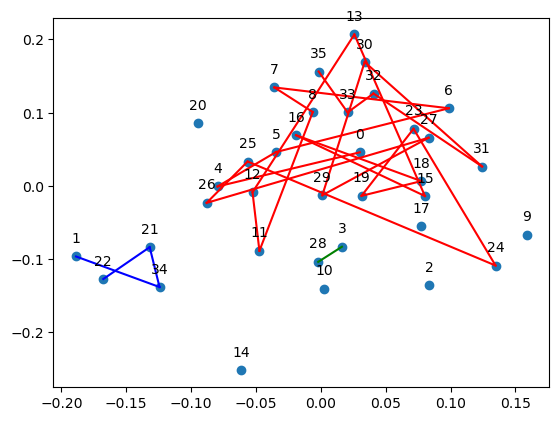

persistence =0.1066401643474133, finding: [3, 15]
 [[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[3, 28], [0, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.556349186104045 15.556349186104045
pbow:
[array([ 5.,  9., 11.,  0.]), array([2., 0., 0., 1.])]
[[ 0.         14.56021978]
 [14.56021978  0.        ]]
score x0.5: [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


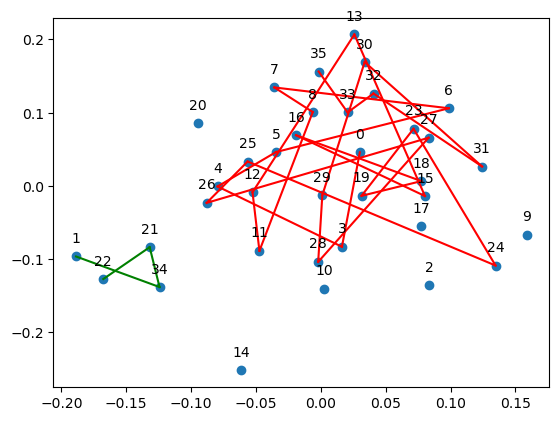

persistence =0.11285515380129885, finding: [2, 17]
 [[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[]
[]
pbow:
[array([0., 1.]), array([16.,  9.]), array([3., 0.])]
[[ 0.         17.88854382  3.16227766]
 [17.88854382  0.         15.8113883 ]
 [ 3.16227766 15.8113883   0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


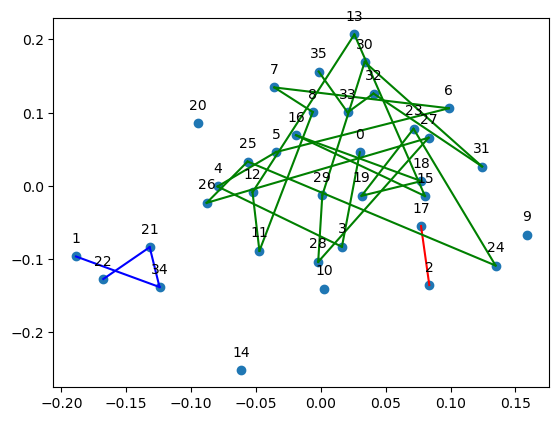

persistence =0.11305858669145585, finding: [17, 19]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [2, 17]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.88854381999832 17.88854381999832
pbow:
[array([ 5.,  8., 11.,  3.]), array([3., 0., 0., 0.])]
[[ 0.         14.07124728]
 [14.07124728  0.        ]]
score x0.5333333333333333: [0.17857142857142858] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


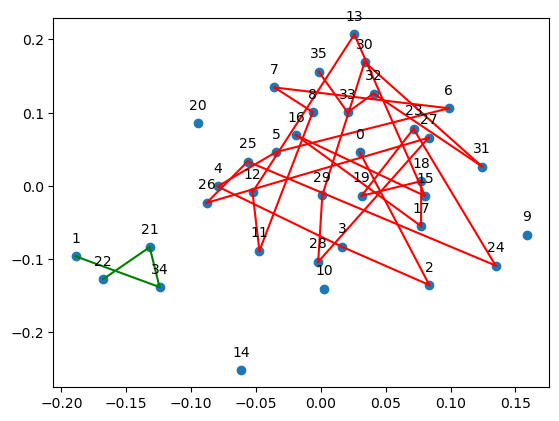

persistence =0.11491700821670836, finding: [10, 11]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[10]]
[[0, 0]]
pbow:
[array([ 9., 11.,  5.,  3.]), array([0., 0., 3., 0.])]
[[ 0.        14.6628783]
 [14.6628783  0.       ]]
score x0.55: [0.1724137931034483] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


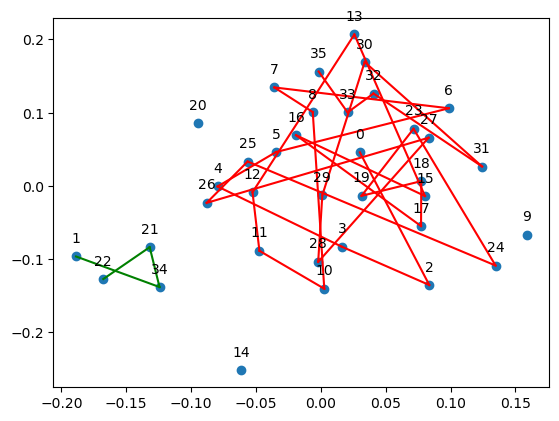

persistence =0.11920610546954824, finding: [4, 20]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[20]]
[[0, 0]]
pbow:
[array([11.,  4.,  5.,  9.]), array([0., 0., 3., 0.])]
[[ 0.         14.89966443]
 [14.89966443  0.        ]]
score x0.5666666666666667: [0.16666666666666666] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


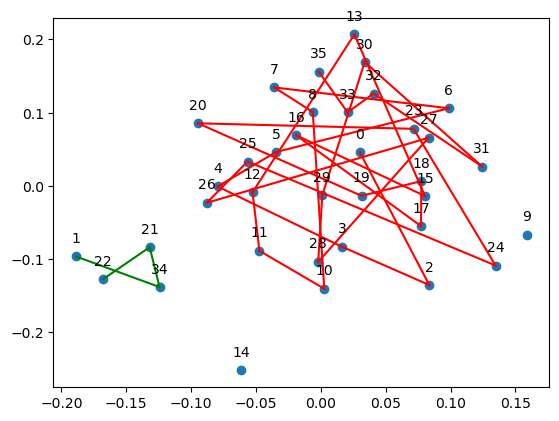

persistence =0.12076519767775173, finding: [28, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[1, 21, 22, 34], [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.89966442575134 14.89966442575134
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.12252427278289424, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[9]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



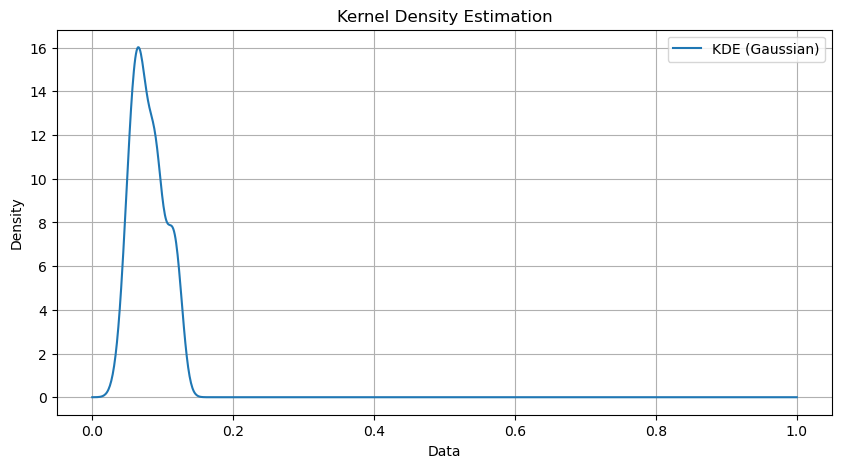

30 (36, 36)


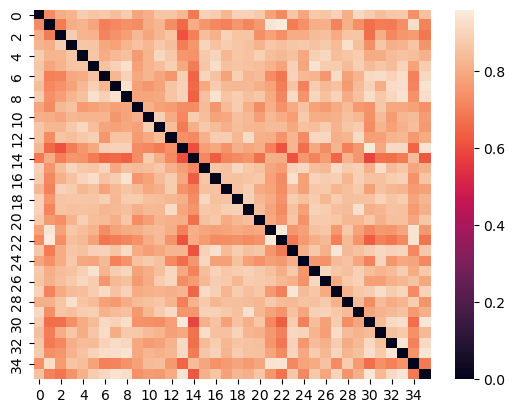

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


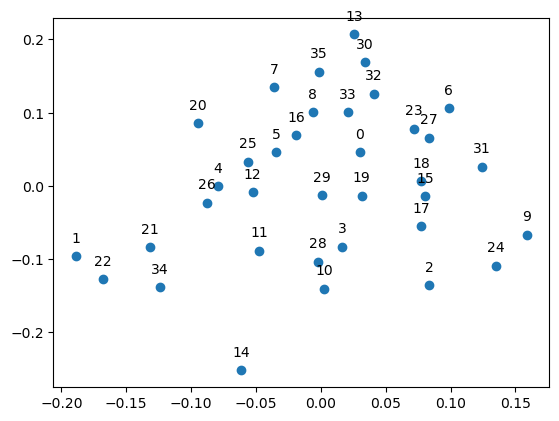

d 0 0 0.0 inf []
d 0 1 0.0 0.1225242149664908 [[10, 14]]
d 0 2 0.0 0.1207651369508348 [[9, 18]]
d 0 3 0.0 0.11920610390836994 [[28, 34]]
d 0 4 0.0 0.11491693702177275 [[4, 20]]
d 0 5 0.0 0.11305858498873667 [[10, 11]]
d 0 6 0.0 0.11285523029631173 [[17, 19]]
d 0 7 0.0 0.10663974473723703 [[2, 17]]
d 0 8 0.0 0.09875942769561841 [[3, 15]]
d 0 9 0.0 0.09143941632747965 [[15, 24]]
d 0 10 0.0 0.09135255057451352 [[4, 26]]
d 0 11 0.0 0.09105915701602396 [[25, 26]]
d 0 12 0.0 0.08917617273448308 [[15, 18]]
d 0 13 0.0 0.08905059329761666 [[4, 11]]
d 0 14 0.0 0.089040582134569 [[12, 25]]
d 0 15 0.0 0.08692008614175883 [[0, 29]]
d 0 16 0.0 0.0837559426114235 [[12, 29]]
d 0 17 0.0 0.07564522145255825 [[6, 33]]
d 0 18 0.0 0.07500840533320796 [[15, 31]]
d 0 19 0.0 0.07415333832212312 [[27, 31]]
d 0 20 0.0 0.0688161699388733 [[5, 8]]
d 0 21 0.0 0.06878081773607536 [[16, 23]]
d 0 22 0.0 0.0687429510985017 [[3, 28]]
d 0 23 0.0 0.06868329223865077 [[19, 29]]
d 0 24 0.0 0.06487865112355162 [[7, 8]]
d 0 

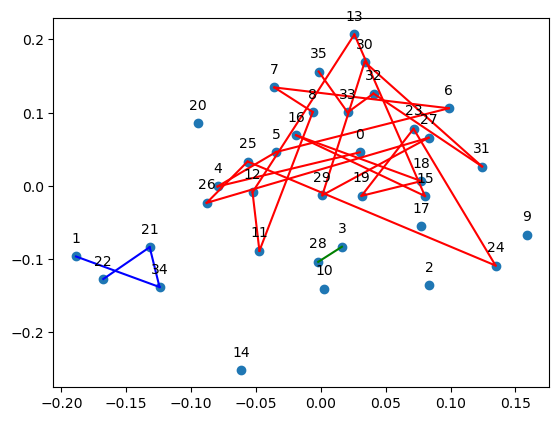

persistence =0.10663974473723703, finding: [3, 15]
 [[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[3, 28], [0, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.556349186104045 15.556349186104045
pbow:
[array([11.,  9.,  5.,  0.]), array([0., 0., 2., 1.])]
[[ 0.         14.56021978]
 [14.56021978  0.        ]]
score x0.5: [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


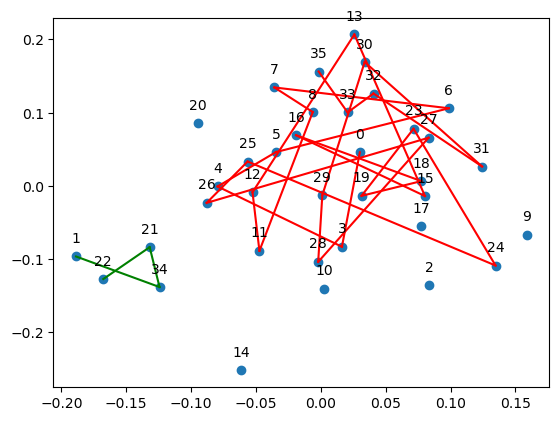

persistence =0.11285523029631173, finding: [2, 17]
 [[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[]
[]
pbow:
[array([0., 1.]), array([16.,  9.]), array([3., 0.])]
[[ 0.         17.88854382  3.16227766]
 [17.88854382  0.         15.8113883 ]
 [ 3.16227766 15.8113883   0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.25] 
total score : 0.8333333333333334

[[2, 17], [0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


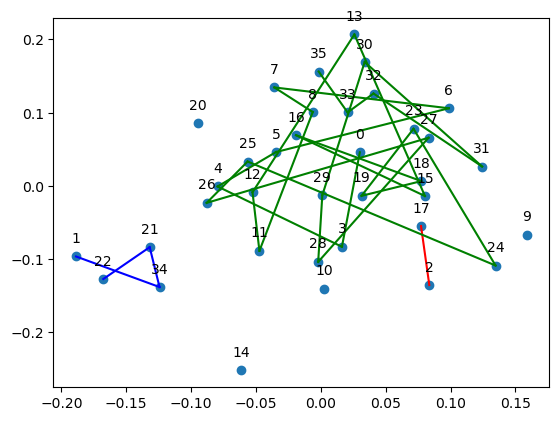

persistence =0.11305858498873667, finding: [17, 19]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[0, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [2, 17]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  17.88854381999832 17.88854381999832
pbow:
[array([11.,  8.,  5.,  3.]), array([0., 0., 3., 0.])]
[[ 0.         14.07124728]
 [14.07124728  0.        ]]
score x0.5333333333333333: [0.17857142857142858] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


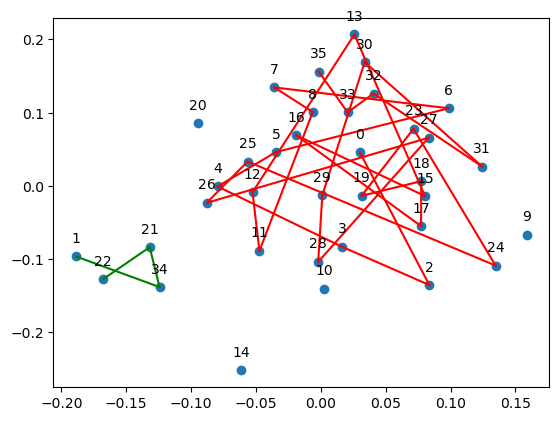

persistence =0.11491693702177275, finding: [10, 11]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[10]]
[[0, 0]]
pbow:
[array([11.,  9.,  5.,  3.]), array([0., 0., 3., 0.])]
[[ 0.        14.6628783]
 [14.6628783  0.       ]]
score x0.55: [0.1724137931034483] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


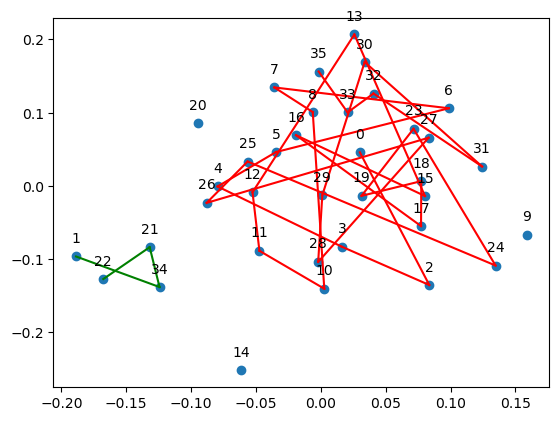

persistence =0.11920610390836994, finding: [4, 20]
 [[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]
merging
[[20]]
[[0, 0]]
pbow:
[array([ 4.,  5.,  9., 11.]), array([0., 3., 0., 0.])]
[[ 0.         14.89966443]
 [14.89966443  0.        ]]
score x0.5666666666666667: [0.16666666666666666] [0.25] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22]]


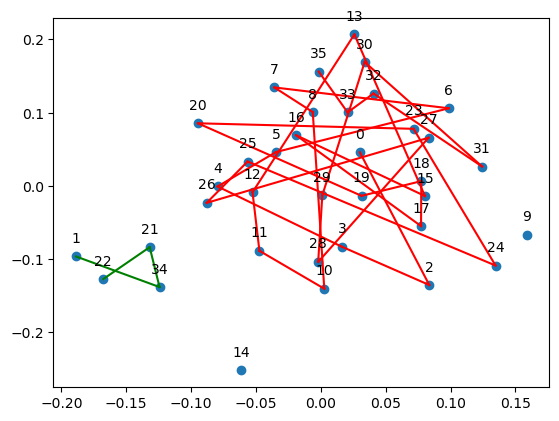

persistence =0.1207651369508348, finding: [28, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[1, 21, 22, 34], [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.89966442575134 14.89966442575134
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.1225242149664908, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[9]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



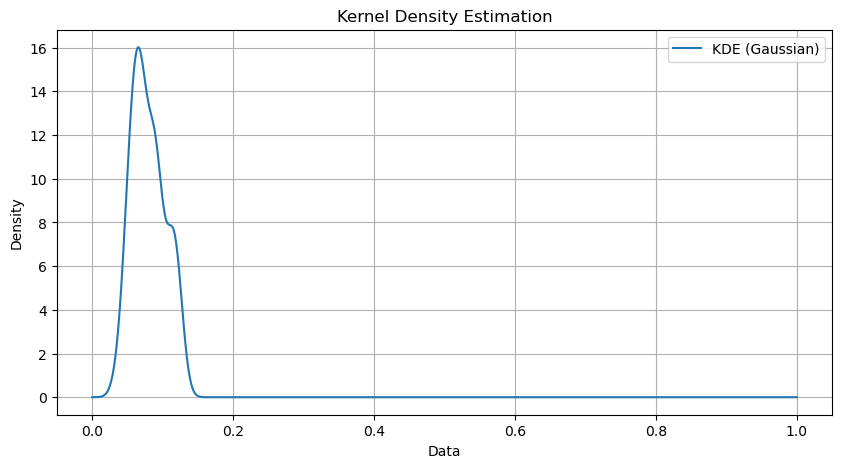

In [14]:
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_number, data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()

    # Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    mds_results = mds.fit_transform(data)

    # Plot the points
    plt.scatter(mds_results[:, 0], mds_results[:, 1])

    for i, points in enumerate(mds_results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

    rips_complex = gd.RipsComplex(distance_matrix=data, max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()

    
    count = 0
    results = []
    dv_seq = []

    for (birth_value, death_value), d in [(i[1], i[0]) for i in persistence if i[0] == 0]:
        tolerance = 1e-6
        birth_simplices = []
        death_simplices = []
        filtration = simplex_tree.get_filtration()

        for simplex, filtration_value in filtration:
            # print(filtration_value, birth_value)
            if abs(filtration_value - birth_value) < tolerance:
                # print(simplex)
                birth_simplices.append(simplex)
            elif abs(filtration_value - death_value) < tolerance or (death_value == np.Inf and d != 0):
                death_simplices.append(simplex)
                
        involved_points_d = (mergeSublistsWithSharedItems(death_simplices))

        if len(involved_points_d) >= 0 : 
            print('d', d, count, birth_value, death_value, involved_points_d) 
            results.append([death_value, involved_points_d])
            dv_seq.append(death_value)
        count += 1
    print("the gaps:")
    print(findLargestGaps(dv_seq, 3))
    
    a = []
    for [death_value, concern_points] in results:
        for c in concern_points:
            # print(c)
            a.append(c)
            
    print(a)
    last_merged = None
    last_distance = None
    score = 0
    has_draw = False
    for i in range(min(len(a)-1, len(results)-1), -1, -1):
        warn_flag = False
        f = flatten(a[i:len(a)])
        if (np.unique(f).shape[0] == total_nums):
            continue
        merged = mergeSublistsWithSharedItems(a[i:len(a)])
        print(f"persistence ={results[i][0]}, finding: {a[i]}\n", merged)
        # print(merged, last_merged)
        score = getTotalLength(merged)/normal_nums/2

        newly_merged = []
        newly_added = []
        merging = []

        if (last_merged != None and len(last_merged)):
            print("merging")
            for idxa, list_a in enumerate(last_merged):
                for idxb, list_b in enumerate(merged):
                    # print(list_a, list_b)
                    if (isProperSuperset(list_a, list_b)):
                        newly_merged.append([idxa, idxb])
                        newly_added.append(findDifferentElements(list_a, list_b))
        
            print(newly_added)
            print(newly_merged)

            if (len(newly_merged) >= 2):
                merging = list(set(newly_merged[0] + newly_merged[1]))
                # merging = find_different_elements(newly_merged[0], newly_merged[1])
                print(merging)
                # print(last_distance)
                if(len(merging) and last_distance.shape[0] > max(merging[-1], merging[-2])):
                    print("merging with pbow_d: ",last_distance[merging[-1]][merging[-2]], np.max(last_distance))
                    if (last_distance[merging[-1]][merging[-2]] >= np.max(last_distance)/2 and score > 0.6 ):
                        print("warn")
                        warn_flag = True
                        a[i] = [0, 0]
                        merged = copy.deepcopy(last_merged)

        
        last_merged = copy.deepcopy(merged)


        
        sub_pers = []
        min_length = float('Inf')
        for sub_points in merged:
            if (len(sub_points) <= 1):
                continue
            min_length = min(min_length, len(sub_points))
            sub_diagram = gd.RipsComplex(distance_matrix=np.array(data)[sub_points][:,sub_points], max_edge_length=100)
            sub_simplex_tree = sub_diagram.create_simplex_tree(max_dimension=2)
            sub_persistence = sub_simplex_tree.persistence()
            sub_pd = np.array([[b, d] for dim, (b, d) in sub_persistence if (dim == 0) and (d != float('inf'))])
            sub_pers.append(sub_pd)

        if (len(sub_pers) > 1 and min_length > 1):
            pbow = perscode.PBoW(N = min(5, min_length), normalize = False)
            pbow_diagrams  = pbow.transform(sub_pers)
            print("pbow:")
            print(pbow_diagrams)
            pbow_distance = np.zeros((len(pbow_diagrams),len(pbow_diagrams)))
            for k in range(len(pbow_diagrams)):
                for j in range(len(pbow_diagrams)):
                    pbow_distance[k][j] = np.linalg.norm(pbow_diagrams[k] - pbow_diagrams[j])
            print(pbow_distance)
        
            if (not warn_flag):
                last_distance = copy.deepcopy(pbow_distance)

        print(f"score x{score}: ",end='')
        total_errors = 0
        for j in merged:
            print([np.mean(np.array(j) >= normal_nums)], end=' ')
            total_errors += min(np.sum((np.array(j) >= normal_nums) == 0),np.sum((np.array(j) >= normal_nums) == 1))
        print(f"\ntotal score : {1- total_errors/data.shape[0]}")
        print()

        if (score >= 0.5 and len(merged) > 1):
            plt.clf()
            plt.scatter(mds_results[:, 0], mds_results[:, 1])
            for idx, points in enumerate(mds_results):
                plt.annotate(idx, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')

            # print(merged)
            draw_point_set = copy.deepcopy(merged)
            colors = ['r', 'g', 'b']
            for color, layer in enumerate(merged):
                # print(layer)
                for p in range(len(layer)-1):
                    p1 = mds_results[layer[p]]
                    p2 = mds_results[layer[p + 1]]
                    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], colors[color]+'-')
            has_draw = True
            print(draw_point_set)
            plt.show()

    if (has_draw):
        pass

    group = np.zeros((total_nums,total_nums))
    for i in mergeSublistsWithSharedItems(a)[0]:
        group[i][i] = 1

    
    X = np.array([x for x in dv_seq if x != float('Inf')])
    X = X.reshape(-1, 1)

    # 初始化KDE模型
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

    # 进行密度估计
    X_sample = np.linspace(0, 1, 1000).reshape(-1, 1)
    log_dens = kde.score_samples(X_sample)

    plt.figure(figsize=(10, 5))
    plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
    plt.title('Kernel Density Estimation')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plt.scatter(mds_results[:, 0], mds_results[:, 1])
    # for i, points in enumerate(mds_results):
    #     plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    # plt.show()


In [15]:


# 生成样本数据
X = np.array([x for x in dv_seq if x != float('Inf')])
X = X.reshape(-1, 1)

# 初始化KDE模型
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

# 进行密度估计
X_sample = np.linspace(-0.5, 0.5, 1000).reshape(-1, 1)
log_dens = kde.score_samples(X_sample)


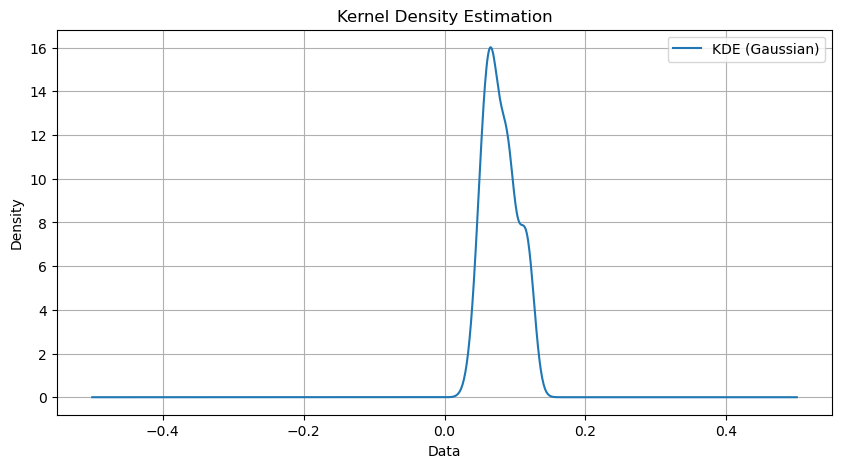

In [16]:
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
plt.title('Kernel Density Estimation')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
%matplotlib inline
for corr in corr_set:
    data = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
    Z = linkage(data, 'ward')
    # Z = linkage(scipy.spatial.distance.squareform(corr.reshape(-1,99) + corr.reshape(-1,99).T), 'ward')
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(Z)
    plt.show()
    num_clusters = 2
    clusters = np.array(fcluster(Z, num_clusters, criterion='maxclust'))
    print(clusters)
    print(1 - abs(np.mean(clusters-1) - 0.5))
    cluster_matrices = {}

    # 根据聚类结果，将距离矩阵划分为num_clusters个子矩阵
    for cluster_id in range(1, num_clusters + 1):
        # 获取属于当前聚类簇的数据点索引
        cluster_indices = np.where(clusters == cluster_id)[0]
        
        # 根据索引获取子矩阵
        sub_matrix = data[cluster_indices][:, cluster_indices]
        
        # 将子矩阵添加到字典中
        cluster_matrices[cluster_id] = sub_matrix

    %matplotlib inline
    for idx in range(1, len(cluster_matrices)+1):
        # data = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
        data = cluster_matrices[idx]
        print(data.shape)
        # df=pd.DataFrame(data)
        # plot=seaborn.heatmap(df)
        # plt.show()
        sns.heatmap(1-data)
        plt.show()

        # Apply Multidimensional Scaling
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
        mds_results = mds.fit_transform(data)

        # Plot the points
        plt.scatter(mds_results[:, 0], mds_results[:, 1])

        for i, points in enumerate(mds_results):
            plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
        plt.show()

        rips_complex = gd.RipsComplex(distance_matrix=data, max_edge_length=100)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence()

        
        count = 0
        results = []

        for (birth_value, death_value), d in [(i[1], i[0]) for i in persistence if i[0] == 0]:
            tolerance = 1e-6
            birth_simplices = []
            death_simplices = []
            filtration = simplex_tree.get_filtration()

            for simplex, filtration_value in filtration:
                # print(filtration_value, birth_value)
                if abs(filtration_value - birth_value) < tolerance:
                    # print(simplex)
                    birth_simplices.append(simplex)
                elif abs(filtration_value - death_value) < tolerance or (death_value == np.Inf and d != 0):
                    death_simplices.append(simplex)
                    
            involved_points_d = (merge_sublists_with_shared_items(death_simplices))

            if len(involved_points_d) >= 0 : 
                print('d', d, count, birth_value, death_value, involved_points_d) 
                results.append([death_value, involved_points_d])
            count += 1
        
        prefixSum = np.zeros(len(results)-2)
        prefixSum[0] = results[2][0]
        for i in range (3, len(prefixSum)-1):
            prefixSum[i-2] = (prefixSum[i-3]+results[i][0])
        
        partitionIdx = 0
        maxDifference = 0.0
        for i in range (0, len(prefixSum)):
            avg1 = prefixSum[i] / (i + 1)
            avg2 = (prefixSum[len(prefixSum)-1] - prefixSum[i]) / (len(prefixSum) - i - 1)
            difference = abs(avg1 - avg2)

            if (difference > maxDifference):
                partitionIdx = i
                maxDifference = difference

        print(f"Break point is {partitionIdx}")


        a = []
        for [death_value, concern_points] in results:
            for c in concern_points:
                # print(c)
                a.append(c)
                
        print(a)
        last_merged = None
        last_distance = None
        score = 0
        for i in range(min(len(a)-1, len(results)-1), -1, -1):
            warn_flag = False
            f = flatten(a[i:len(a)])
            if (np.unique(f).shape[0] == client_max*2):
                continue
            merged = merge_sublists_with_shared_items(a[i:len(a)])
            print(f"persistence ={results[i][0]}, finding: {a[i]}\n", merged)
            # print(merged, last_merged)
            score = get_total_length(merged)/client_max/2

            newly_merged = []
            newly_added = []
            merging = []

            if (last_merged != None and len(last_merged)):
                print("merging")
                for idxa, list_a in enumerate(last_merged):
                    for idxb, list_b in enumerate(merged):
                        # print(list_a, list_b)
                        if (is_proper_superset(list_a, list_b)):
                            newly_merged.append([idxa, idxb])
                            newly_added.append(find_different_elements(list_a, list_b))
            
                print(newly_added)
                print(newly_merged)

                if (len(newly_merged) >= 2):
                    merging = list(set(newly_merged[0] + newly_merged[1]))
                    # merging = find_different_elements(newly_merged[0], newly_merged[1])
                    print(merging)
                    # print(last_distance)
                    if(len(merging) and last_distance.shape[0] > max(merging[-1], merging[-2])):
                        print("merging with pbow_d: ",last_distance[merging[-1]][merging[-2]], np.max(last_distance))
                        if (last_distance[merging[-1]][merging[-2]] >= np.max(last_distance)/2 and score > 0.6 ):
                            print("warn")
                            warn_flag = True
                            a[i] = [0, 0]
                            merged = copy.deepcopy(last_merged)

            
            last_merged = copy.deepcopy(merged)


            
            sub_pers = []
            min_length = float('Inf')
            for sub_points in merged:
                if (len(sub_points) <= 1):
                    continue
                min_length = min(min_length, len(sub_points))
                sub_diagram = gd.RipsComplex(distance_matrix=np.array(data)[sub_points][:,sub_points], max_edge_length=100)
                sub_simplex_tree = sub_diagram.create_simplex_tree(max_dimension=2)
                sub_persistence = sub_simplex_tree.persistence()
                sub_pd = np.array([[b, d] for dim, (b, d) in sub_persistence if (dim == 0) and (d != float('inf'))])
                sub_pers.append(sub_pd)

            if (len(sub_pers) > 1 and min_length > 1):
                pbow = perscode.PBoW(N = min(5, min_length), normalize = False)
                pbow_diagrams  = pbow.transform(sub_pers)
                print("pbow:")
                print(pbow_diagrams)
                pbow_distance = np.zeros((len(pbow_diagrams),len(pbow_diagrams)))
                for i in range(len(pbow_diagrams)):
                    for j in range(len(pbow_diagrams)):
                        pbow_distance[i][j] = np.linalg.norm(pbow_diagrams[i] - pbow_diagrams[j])
                print(pbow_distance)
            
                if (not warn_flag):
                    last_distance = copy.deepcopy(pbow_distance)

            print(f"score x{score}: ",end='')
            for j in merged:
                print([np.mean(np.array(j) >= client_max)], end=' ')
            print()


        group = np.zeros((client_max*2,client_max*2))
        for i in merge_sublists_with_shared_items(a)[0]:
            group[i][i] = 1


        

AttributeError: 'list' object has no attribute 'reshape'